In [1]:
%tensorflow_version 1.X
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.X`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [2]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 108kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model, Sequential
from keras.datasets import fashion_mnist
from keras import activations
from keras.preprocessing import image

from vis.visualization import visualize_activation,visualize_saliency,overlay,visualize_cam
from vis.utils import utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

Using TensorFlow backend.


##Download data

In [3]:
!mkdir tmp

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O tmp/rps-test-set.zip

--2020-08-12 01:41:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘tmp/rps.zip’

tmp/rps.zip         100%[===================>] 191.38M  28.6MB/s    in 6.7s    

2020-08-12 01:41:09 (28.6 MB/s) - ‘tmp/rps.zip’ saved [200682221/200682221]

--2020-08-12 01:41:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘tmp/rps

##Unzip data

In [4]:
import os
import zipfile

local_zip = 'tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

local_zip = 'tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

In [5]:
rock_dir = os.path.join('tmp/rps/rock')
paper_dir = os.path.join('tmp/rps/paper')
scissors_dir = os.path.join('tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:5])

paper_files = os.listdir(paper_dir)
print(paper_files[:5])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:5])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock02-085.png', 'rock02-069.png', 'rock07-k03-015.png', 'rock04-032.png', 'rock03-084.png']
['paper03-067.png', 'paper03-046.png', 'paper03-010.png', 'paper04-000.png', 'paper01-025.png']
['testscissors02-109.png', 'scissors01-104.png', 'scissors04-047.png', 'testscissors01-114.png', 'scissors02-009.png']


##View some data

tmp/rps/rock/rock02-085.png


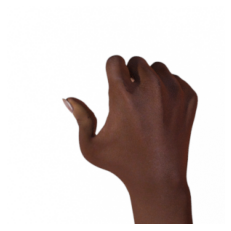

tmp/rps/rock/rock02-069.png


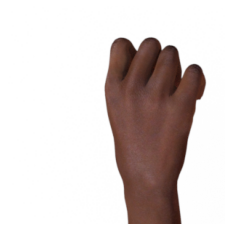

tmp/rps/paper/paper03-067.png


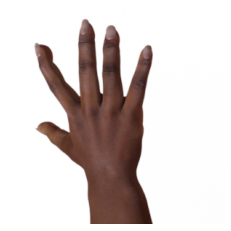

tmp/rps/paper/paper03-046.png


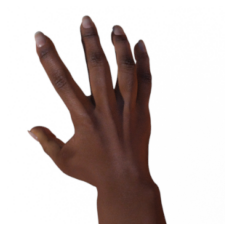

tmp/rps/scissors/testscissors02-109.png


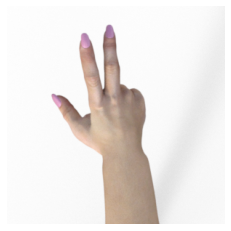

tmp/rps/scissors/scissors01-104.png


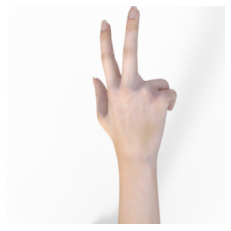

In [6]:
pic_index = 2

next_rock = [os.path.join(rock_dir, fname) for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

##Data pre-process

In [7]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


### Check the labels

In [8]:
# make sure two dictionaries are the same
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

{0: 'paper', 1: 'rock', 2: 'scissors'}
{0: 'paper', 1: 'rock', 2: 'scissors'}


##Make the model

In [9]:
model = Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    # The second convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The third convolution
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The fourth convolution
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    Flatten(),
    Dropout(0.5),
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
______________________________________

##Train the model and save it

In [10]:
history = model.fit_generator(train_generator, epochs=20, validation_data = validation_generator, verbose = 1)
model.save("rps.h5")


Epoch 1/20
79/79 [==============================] - 24s 298ms/step - loss: 1.1604 - accuracy: 0.3821 - val_loss: 1.0150 - val_accuracy: 0.6452
Epoch 2/20
79/79 [==============================] - 20s 253ms/step - loss: 0.8099 - accuracy: 0.6127 - val_loss: 0.1496 - val_accuracy: 0.9355
Epoch 3/20
79/79 [==============================] - 20s 254ms/step - loss: 0.5558 - accuracy: 0.7659 - val_loss: 0.0897 - val_accuracy: 0.9973
Epoch 4/20
79/79 [==============================] - 20s 253ms/step - loss: 0.3879 - accuracy: 0.8540 - val_loss: 0.0447 - val_accuracy: 0.9866
Epoch 5/20
79/79 [==============================] - 20s 250ms/step - loss: 0.2629 - accuracy: 0.8956 - val_loss: 0.0153 - val_accuracy: 0.9597
Epoch 6/20
79/79 [==============================] - 20s 252ms/step - loss: 0.2410 - accuracy: 0.9115 - val_loss: 0.0261 - val_accuracy: 0.9597
Epoch 7/20
79/79 [==============================] - 20s 253ms/step - loss: 0.1776 - accuracy: 0.9433 - val_loss: 0.0070 - val_accuracy: 0.970

##See the training trend

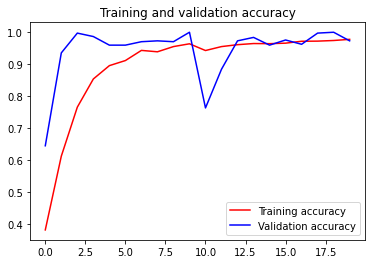

<Figure size 432x288 with 0 Axes>

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Modify the last layer of the model to make CAM model

In [12]:
model_h = model
# We can specify the last layer as -1
print("Remove Activation from Last Layer")
# Swap softmax with linear
model_h.layers[-1].activation = activations.linear
print("Done. Now Applying changes to the model ...")
model_h = utils.apply_modifications(model_h)

Remove Activation from Last Layer
Done. Now Applying changes to the model ...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


##Test the model

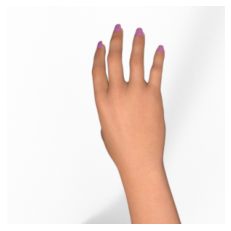

original image shape: (300, 300, 4)
resized image shape: (150, 150, 3)
shape of the x for the model: (1, 150, 150, 3)
predicted class: [0]
the folder name is: paper


In [28]:
# predicting images
path = "tmp/rps-test-set/paper/testpaper01-28.png"
#path = "tmp/rps-test-set/rock/testrock01-05.png"
#path = "tmp/rps-test-set/scissors/testscissors01-05.png"

# show the image
img = mpimg.imread(path)
plt.imshow(img)
plt.axis('Off')
plt.show()
print("original image shape:", img.shape)

# resize the image
img = image.load_img(path, target_size=(150, 150))
img = image.img_to_array(img)
print("resized image shape:", img.shape)
x = np.expand_dims(img, axis=0) / 255 # remember to divide by 255
print("shape of the x for the model:", x.shape)

# predict_classes
classes = model.predict_classes(x)
print("predicted class:", classes)
class_name = labels[classes[0]]
print("the folder name is:", class_name)

## Generate heatmap of the predicted image

(150, 150, 3)


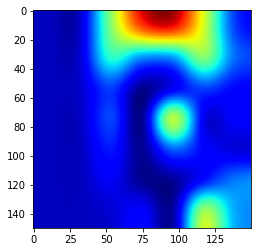

In [29]:
heatmap = visualize_cam(model_h, -1, filter_indices=2, seed_input=x[0,:,:,:])
print(heatmap.shape)
plt.imshow(heatmap)

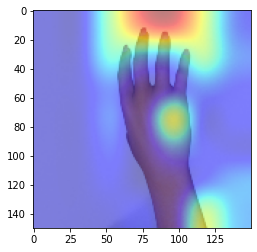

In [30]:
plt.imshow(overlay(img, heatmap).astype('uint8'))

Reference: https://edebrouwer.github.io/deeplearning/carvision/visualization/neural/networks/learning/2017/08/09/Deep_Visualization.html?fbclid=IwAR2q6RpfM--vxNmY2sSj9FHCxsm3BJ_7SjBbYDsOhH1puELTx0qK2h4M1m8